In [11]:
import torch
import torchvision
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [12]:
iterable = (0 for i in range(10))


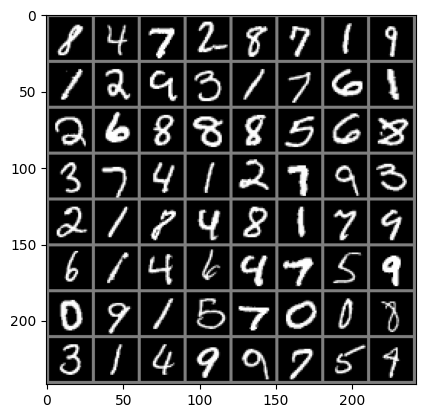

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# Show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# design a simple autoencoder model, where the encoder are CNN and the decoder are fully connected layers
# the imput are 28*28=784, and the output are also 784

# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(784, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 12)
#         self.fc4 = nn.Linear(12, 3)
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.relu(self.fc4(x))
#         return x
    
class CNNEncoder(nn.Module):
    def __init__(self,latent_dim):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)  # 1*28*28 -> 16*14*14
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # 16*14*14 -> 32*7*7
        self.conv3 = nn.Conv2d(32, 64, 7)  # 32*7*7 -> 64*1*1
        self.fc = nn.Linear(64, latent_dim)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x
    
class CNNDecoder(nn.Module):
    def __init__(self,latent_dim):
        super(CNNDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64)
        self.conv3 = nn.ConvTranspose2d(64, 32, 7)  # 64*1*1 -> 32*7*7
        self.conv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)  # 32*7*7 -> 16*14*14
        self.conv1 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)  # 16*14*14 -> 1*28*28
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 64, 1, 1)  # reshape
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = F.tanh(self.conv1(x))
        return x
    
class AutoEncoder(nn.Module):
    def __init__(self,latent_dim):
        super(AutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEnco  der(latent_dim)
        self.decoder = CNNDecoder(latent_dim)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm
from dataclasses import dataclass   

def train_model(model,device='cpu'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 100
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for images, _ in trainloader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")


In [16]:
def show_images(original, reconstructed):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(np.transpose(torchvision.utils.make_grid(original).numpy(), (1, 2, 0)))
    axes[0].set_title('Original Images')
    axes[1].imshow(np.transpose(torchvision.utils.make_grid(reconstructed.view(-1, 1, 28, 28)).detach().numpy(), (1, 2, 0)))
    axes[1].set_title('Reconstructed Images')
    plt.show()
    
def test_model(model,device='cpu'):
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
    test_dataiter = iter(testloader)
    test_images, _ = next(test_dataiter)
    reconstructed_images = model(test_images.to(device)).to('cpu')

    show_images(test_images, reconstructed_images)

    # Generate a grid of random samples
    random_samples = torch.randn(64, model.latent_dim)
    random_samples = (random_samples - random_samples.mean(dim=0)) / random_samples.std(dim=0)
    generated_images = model.decoder(random_samples.to(device)).to('cpu')
    generated_images = generated_images.view(64, 1, 28, 28)
    grid_img = torchvision.utils.make_grid(generated_images, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0).detach().numpy(), cmap='gray')
    plt.title('Generated Images from Random Samples')
    plt.gcf().set_size_inches(3, 3)
    plt.show()

training with latent_dim = 2


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.22430080906160352
Epoch 2, Loss: 0.1874873693277841
Epoch 3, Loss: 0.1789312868007719
Epoch 4, Loss: 0.17433460398332906
Epoch 5, Loss: 0.1712064380838927
Epoch 6, Loss: 0.16886780598460993
Epoch 7, Loss: 0.1670238727540858
Epoch 8, Loss: 0.16551968552219842
Epoch 9, Loss: 0.16436928666349668
Epoch 10, Loss: 0.16334162561941756
Epoch 11, Loss: 0.16251127796767872
Epoch 12, Loss: 0.16171287559369987
Epoch 13, Loss: 0.1610841052586844
Epoch 14, Loss: 0.1603585103554512
Epoch 15, Loss: 0.1598325508839286
Epoch 16, Loss: 0.15934134419284648
Epoch 17, Loss: 0.15890395403035415
Epoch 18, Loss: 0.15844871707435357
Epoch 19, Loss: 0.1579477616559976
Epoch 20, Loss: 0.15755905685966204
Epoch 21, Loss: 0.15727133685147077
Epoch 22, Loss: 0.15703324738468952
Epoch 23, Loss: 0.15664578755018807
Epoch 24, Loss: 0.15640649282093497
Epoch 25, Loss: 0.15610984719193566
Epoch 26, Loss: 0.155812908099023
Epoch 27, Loss: 0.15560933351834447
Epoch 28, Loss: 0.15538790318439763
Epoch 29, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100, Loss: 0.1486443577926042


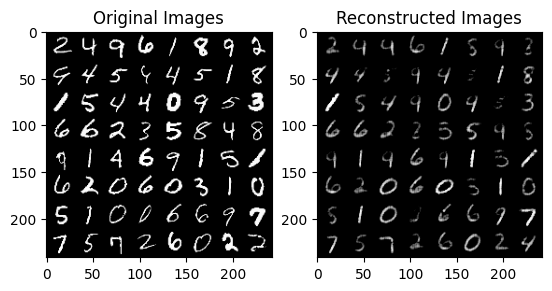

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


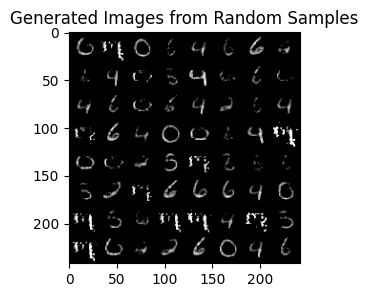

training with latent_dim = 4


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.21902978917492477
Epoch 2, Loss: 0.14746984425606505
Epoch 3, Loss: 0.13612466202234663
Epoch 4, Loss: 0.13021869399844965
Epoch 5, Loss: 0.12652260100028154
Epoch 6, Loss: 0.12403380415682345
Epoch 7, Loss: 0.12223019742412862
Epoch 8, Loss: 0.1207658890912782
Epoch 9, Loss: 0.11960359943955183
Epoch 10, Loss: 0.1184983434024523
Epoch 11, Loss: 0.11773735859087789
Epoch 12, Loss: 0.11695325244337257
Epoch 13, Loss: 0.116356691508405
Epoch 14, Loss: 0.11570582349798572
Epoch 15, Loss: 0.11519773487152575
Epoch 16, Loss: 0.11476494690407314
Epoch 17, Loss: 0.11441569591858494
Epoch 18, Loss: 0.11399376922165916
Epoch 19, Loss: 0.11366397935126636
Epoch 20, Loss: 0.1133699965740699
Epoch 21, Loss: 0.11305950790135337
Epoch 22, Loss: 0.11278629659621446
Epoch 23, Loss: 0.11252684809410496
Epoch 24, Loss: 0.11231606765024697
Epoch 25, Loss: 0.1120796297420698
Epoch 26, Loss: 0.11184598616699674
Epoch 27, Loss: 0.11169261511550276
Epoch 28, Loss: 0.11150532113368324
Epoch 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100, Loss: 0.1066166858381427


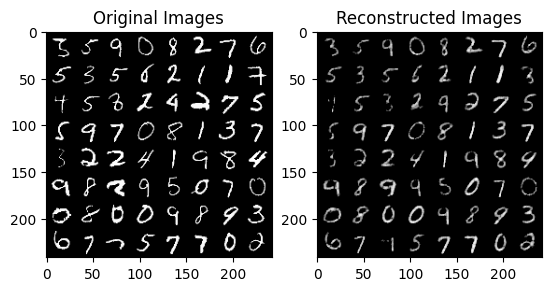

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


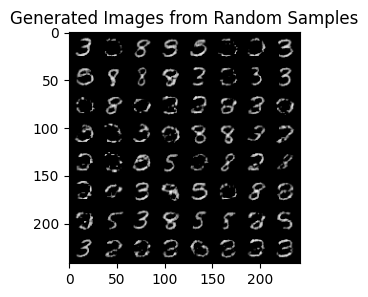

training with latent_dim = 8


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.1620274676617656
Epoch 2, Loss: 0.09154252317954482
Epoch 3, Loss: 0.08352492165082553
Epoch 4, Loss: 0.0793303597504015
Epoch 5, Loss: 0.07661546529657932
Epoch 6, Loss: 0.07474650161019139
Epoch 7, Loss: 0.07323898630403379
Epoch 8, Loss: 0.07211517848805196
Epoch 9, Loss: 0.07116974197598154
Epoch 10, Loss: 0.07039028259593921
Epoch 11, Loss: 0.06972409706157662
Epoch 12, Loss: 0.06918792232775739
Epoch 13, Loss: 0.06864454951494742
Epoch 14, Loss: 0.06825785232044614
Epoch 15, Loss: 0.0677935736718526
Epoch 16, Loss: 0.06745852215854979
Epoch 17, Loss: 0.06714026900782769
Epoch 18, Loss: 0.06678815158620191
Epoch 19, Loss: 0.06656256859808334
Epoch 20, Loss: 0.06632659713755538
Epoch 21, Loss: 0.06608563947525106
Epoch 22, Loss: 0.06588612133855505
Epoch 23, Loss: 0.06571234341686977
Epoch 24, Loss: 0.06548022531640174
Epoch 25, Loss: 0.06532446039653918
Epoch 26, Loss: 0.06518567193831716
Epoch 27, Loss: 0.06505814990572838
Epoch 28, Loss: 0.06487822383721627
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


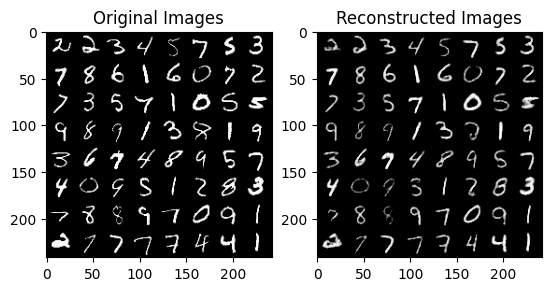

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


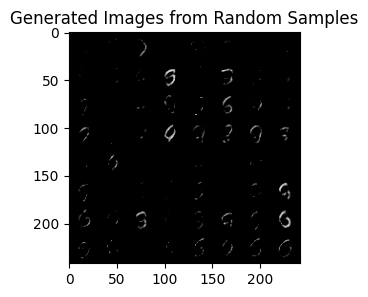

training with latent_dim = 12


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.1732633209018819
Epoch 2, Loss: 0.07805433032164441
Epoch 3, Loss: 0.06486828391676519
Epoch 4, Loss: 0.06033959669043133
Epoch 5, Loss: 0.05770934208719207
Epoch 6, Loss: 0.05576578059049049
Epoch 7, Loss: 0.05402314618452272
Epoch 8, Loss: 0.05243028202719653
Epoch 9, Loss: 0.05097343602668502
Epoch 10, Loss: 0.04969009103726095
Epoch 11, Loss: 0.04866255382532631
Epoch 12, Loss: 0.047749227135261495
Epoch 13, Loss: 0.04709668344319629
Epoch 14, Loss: 0.04653032485054119
Epoch 15, Loss: 0.04603913918868311
Epoch 16, Loss: 0.04563489311666631
Epoch 17, Loss: 0.04525908422686144
Epoch 18, Loss: 0.04486621758624562
Epoch 19, Loss: 0.04460933518165083
Epoch 20, Loss: 0.04435778010104384
Epoch 21, Loss: 0.04416479774788499
Epoch 22, Loss: 0.043917385043143464
Epoch 23, Loss: 0.043763412968881095
Epoch 24, Loss: 0.04351019805301227
Epoch 25, Loss: 0.043346738915390044
Epoch 26, Loss: 0.043235016950983994
Epoch 27, Loss: 0.043030956825579024
Epoch 28, Loss: 0.04294803107121

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100, Loss: 0.03948825363443096


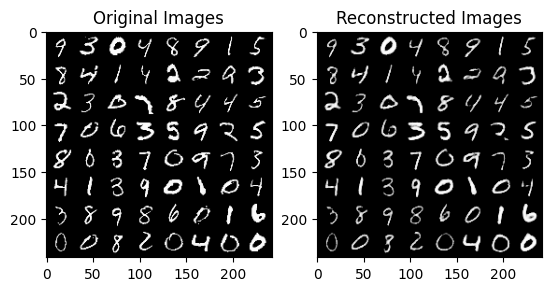

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


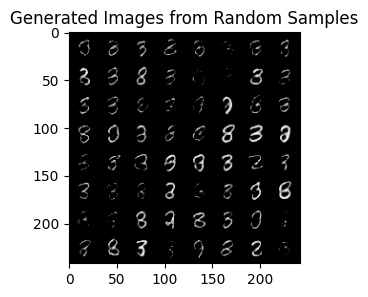

training with latent_dim = 16


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.15945667972061425
Epoch 2, Loss: 0.06419846211383337
Epoch 3, Loss: 0.05003292168746752
Epoch 4, Loss: 0.043431648932921604
Epoch 5, Loss: 0.040776668358713325
Epoch 6, Loss: 0.039281296786040004
Epoch 7, Loss: 0.03829086933936328
Epoch 8, Loss: 0.03747564257938724
Epoch 9, Loss: 0.036858734529791104
Epoch 10, Loss: 0.03634674626507802
Epoch 11, Loss: 0.0358813683619536
Epoch 12, Loss: 0.03549195265472888
Epoch 13, Loss: 0.03512164845522533
Epoch 14, Loss: 0.03483754964763803
Epoch 15, Loss: 0.03453242622895726
Epoch 16, Loss: 0.03425269231382908
Epoch 17, Loss: 0.03400928631766455
Epoch 18, Loss: 0.03378748358376245
Epoch 19, Loss: 0.033564619207655445
Epoch 20, Loss: 0.03339203863120727
Epoch 21, Loss: 0.03319786309099782
Epoch 22, Loss: 0.03304743206998242
Epoch 23, Loss: 0.03287543764889939
Epoch 24, Loss: 0.03272459306505952
Epoch 25, Loss: 0.0325769571615244
Epoch 26, Loss: 0.032467343427463255
Epoch 27, Loss: 0.032318180327667104
Epoch 28, Loss: 0.03224782345455

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100, Loss: 0.029207132822240214


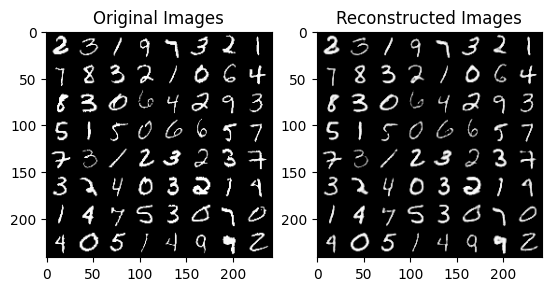

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


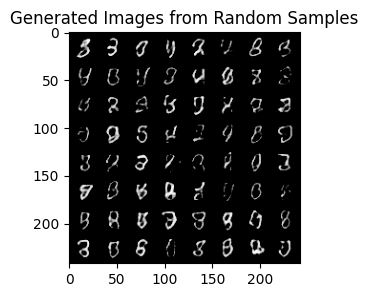

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models = {}
for latent_dim in [2,4,8,12,16]:
    print(f'training with latent_dim =',latent_dim)
    current_model = AutoEncoder(latent_dim=latent_dim)
    models[latent_dim] = current_model
    current_model.to(device)
    train_model(current_model,device)
    test_model(current_model,device)

In [92]:
def gen_latent(model):
    latent_encoded_images = []
    for images,_ in trainloader:
        latent_encoded_images.append(model.encoder(images.to(device)))
        
    latent_X =  torch.concat(latent_encoded_images).cpu().detach().numpy()
    return latent_X

from sklearn.decomposition import PCA
def project_latent(latent_X):    
    pca = PCA(n_components=2) 
    latent_X_pca = pca.fit_transform(latent_X)
    plt.scatter(latent_X_pca[:, 0], latent_X_pca[:, 1], c='b', marker='o',s=1)


training with latent_dim = 2


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.23475497163562123
Epoch 2, Loss: 0.18950558395019726
Epoch 3, Loss: 0.17899159106936283
Epoch 4, Loss: 0.17372916834250188
Epoch 5, Loss: 0.17062754500141022
Epoch 6, Loss: 0.16809506504647515
Epoch 7, Loss: 0.166000906894329
Epoch 8, Loss: 0.1646057511252889
Epoch 9, Loss: 0.1633529308667061
Epoch 10, Loss: 0.1625603269189914
Epoch 11, Loss: 0.16156844297515305
Epoch 12, Loss: 0.1607553598278367
Epoch 13, Loss: 0.1601970852025028
Epoch 14, Loss: 0.1596710834262976
Epoch 15, Loss: 0.159258381374228
Epoch 16, Loss: 0.1587440732763266
Epoch 17, Loss: 0.1582990166570332
Epoch 18, Loss: 0.15800004517599972
Epoch 19, Loss: 0.1576800133897933
Epoch 20, Loss: 0.1573876460064957
Epoch 21, Loss: 0.15702376216014566
Epoch 22, Loss: 0.1567681423350692
Epoch 23, Loss: 0.15649264269291974
Epoch 24, Loss: 0.15617061166493879
Epoch 25, Loss: 0.15599346486553708
Epoch 26, Loss: 0.1558147076604717
Epoch 27, Loss: 0.1554934837257684
Epoch 28, Loss: 0.1553348238820206
Epoch 29, Loss: 0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


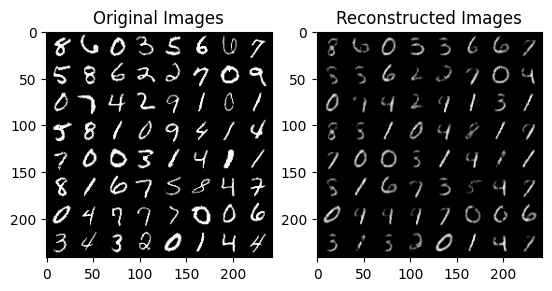

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


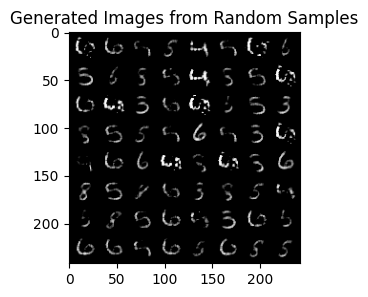

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models = {}


training with latent_dim = 3


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2512878688381933
Epoch 2, Loss: 0.17583194130392216
Epoch 3, Loss: 0.15947607288291968
Epoch 4, Loss: 0.15162473894766906
Epoch 5, Loss: 0.14698284628517083
Epoch 6, Loss: 0.14381337408095535
Epoch 7, Loss: 0.14144982561183128
Epoch 8, Loss: 0.1398014904085253
Epoch 9, Loss: 0.13843216359424693
Epoch 10, Loss: 0.13720860549890157
Epoch 11, Loss: 0.13626542434032793
Epoch 12, Loss: 0.13555767159980497
Epoch 13, Loss: 0.13472168417627622
Epoch 14, Loss: 0.13416023862196694
Epoch 15, Loss: 0.13358086892473164
Epoch 16, Loss: 0.13314739805358305
Epoch 17, Loss: 0.13270069365657722
Epoch 18, Loss: 0.13228309500033159
Epoch 19, Loss: 0.1319296569791811
Epoch 20, Loss: 0.13157069501179114
Epoch 21, Loss: 0.1313202533164004
Epoch 22, Loss: 0.13097311964612018
Epoch 23, Loss: 0.13073620602075478
Epoch 24, Loss: 0.13046125218526386
Epoch 25, Loss: 0.13026809748778465
Epoch 26, Loss: 0.13008147725132482
Epoch 27, Loss: 0.129838861405913
Epoch 28, Loss: 0.12961588626000672
Epoch 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100, Loss: 0.12454690668247402


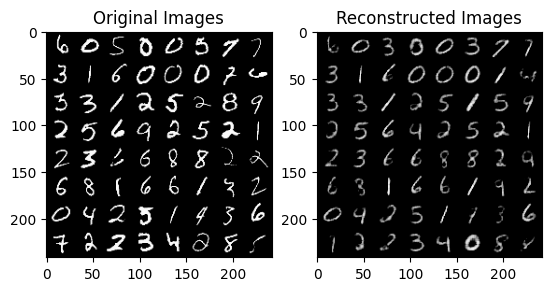

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


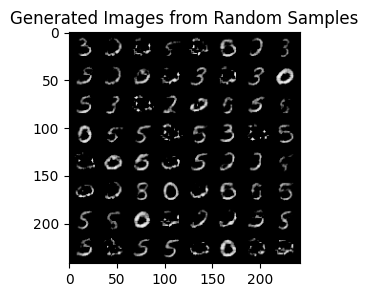

training with latent_dim = 4


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.20856198245909677
Epoch 2, Loss: 0.14062700763757804
Epoch 3, Loss: 0.13106209998414206
Epoch 4, Loss: 0.12650598031975058
Epoch 5, Loss: 0.12360618191995601
Epoch 6, Loss: 0.12162218612235492
Epoch 7, Loss: 0.12020050799414547
Epoch 8, Loss: 0.11906563489834891
Epoch 9, Loss: 0.11812336776238769
Epoch 10, Loss: 0.1172518081454707
Epoch 11, Loss: 0.11655243941302747
Epoch 12, Loss: 0.11593112506782577
Epoch 13, Loss: 0.1153257197932775
Epoch 14, Loss: 0.11485912571393096
Epoch 15, Loss: 0.11430622087612843
Epoch 16, Loss: 0.11396348238118421
Epoch 17, Loss: 0.11358469026461085
Epoch 18, Loss: 0.11324404184021421
Epoch 19, Loss: 0.11287659034132957
Epoch 20, Loss: 0.11259760652809764
Epoch 21, Loss: 0.1123857619141592
Epoch 22, Loss: 0.11206977315612439
Epoch 23, Loss: 0.11179900654692894
Epoch 24, Loss: 0.11156858719869463
Epoch 25, Loss: 0.11136339191021695
Epoch 26, Loss: 0.11113627592542533
Epoch 27, Loss: 0.11101674638005463
Epoch 28, Loss: 0.11077656993257211
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100, Loss: 0.10611385722626755


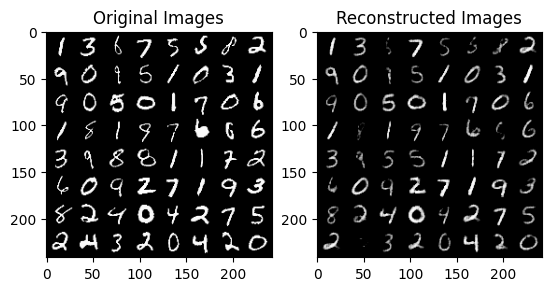

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


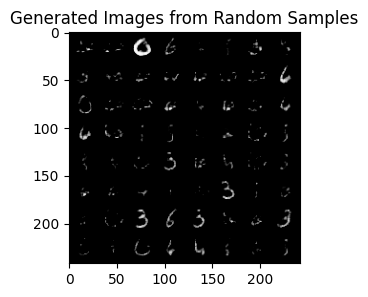

training with latent_dim = 8


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.15735246452377805
Epoch 2, Loss: 0.08902820895539164
Epoch 3, Loss: 0.08182545608358342
Epoch 4, Loss: 0.07796272578667095
Epoch 5, Loss: 0.07552438027171819
Epoch 6, Loss: 0.07386780836418874
Epoch 7, Loss: 0.0724416147591844
Epoch 8, Loss: 0.07124789936471977
Epoch 9, Loss: 0.07023925717864464
Epoch 10, Loss: 0.06943110316626426
Epoch 11, Loss: 0.068651152921638
Epoch 12, Loss: 0.0680288749415356
Epoch 13, Loss: 0.0674612038592095
Epoch 14, Loss: 0.06703774104796366
Epoch 15, Loss: 0.06657341148045018
Epoch 16, Loss: 0.06623767581639259
Epoch 17, Loss: 0.06589087671133628
Epoch 18, Loss: 0.06553476807802344
Epoch 19, Loss: 0.06527141781090927
Epoch 20, Loss: 0.06502702038314169
Epoch 21, Loss: 0.06472351192744938
Epoch 22, Loss: 0.0645083510227549
Epoch 23, Loss: 0.06431585658333704
Epoch 24, Loss: 0.06417539395264853
Epoch 25, Loss: 0.06400155911504078
Epoch 26, Loss: 0.06378114519358825
Epoch 27, Loss: 0.06367684509565454
Epoch 28, Loss: 0.0635296290220101
Epoch 29

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100, Loss: 0.0597301738690148


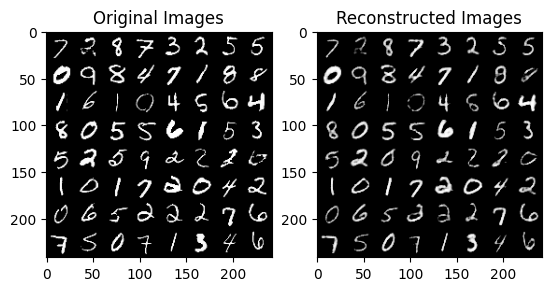

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


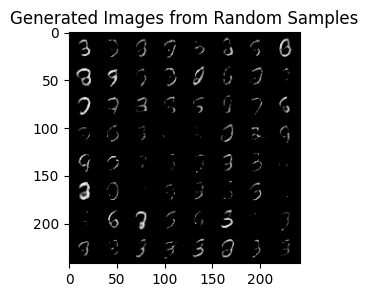

training with latent_dim = 16


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.19815214463610892
Epoch 2, Loss: 0.07711367969955209
Epoch 3, Loss: 0.059704742722038524
Epoch 4, Loss: 0.050062911064703584
Epoch 5, Loss: 0.045109584621751485
Epoch 6, Loss: 0.04262351901975395
Epoch 7, Loss: 0.04101828237109855
Epoch 8, Loss: 0.03984129973558157
Epoch 9, Loss: 0.03894304256560579
Epoch 10, Loss: 0.03828943758082987
Epoch 11, Loss: 0.0376974169883742
Epoch 12, Loss: 0.0372676314698703
Epoch 13, Loss: 0.03684124421638085
Epoch 14, Loss: 0.03648882505418395
Epoch 15, Loss: 0.03613341931325159
Epoch 16, Loss: 0.03581539572063667
Epoch 17, Loss: 0.03550094928640102
Epoch 18, Loss: 0.03518054115055784
Epoch 19, Loss: 0.034927825900171995
Epoch 20, Loss: 0.03461832080139662
Epoch 21, Loss: 0.0343781537227412
Epoch 22, Loss: 0.03411833258238492
Epoch 23, Loss: 0.03392124390884885
Epoch 24, Loss: 0.033707066977233774
Epoch 25, Loss: 0.033500847861424946
Epoch 26, Loss: 0.03332766730870519
Epoch 27, Loss: 0.03313617918616546
Epoch 28, Loss: 0.0330173125637492

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100, Loss: 0.029662331115446493


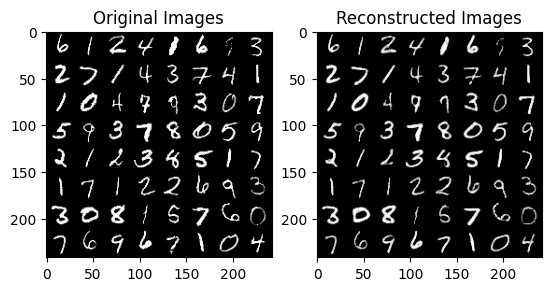

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


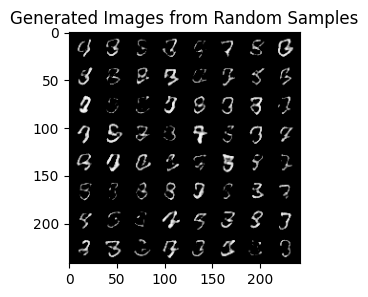

In [61]:
for latent_dim in [3,4,8,16]:
    print(f'training with latent_dim =',latent_dim)
    current_model = AutoEncoder(latent_dim=latent_dim)
    models[latent_dim] = current_model
    current_model.to(device)
    train_model(current_model,device)
    test_model(current_model,device)

In [70]:
latents = {}
latents = {k:gen_latent(models[k]) for k in models}

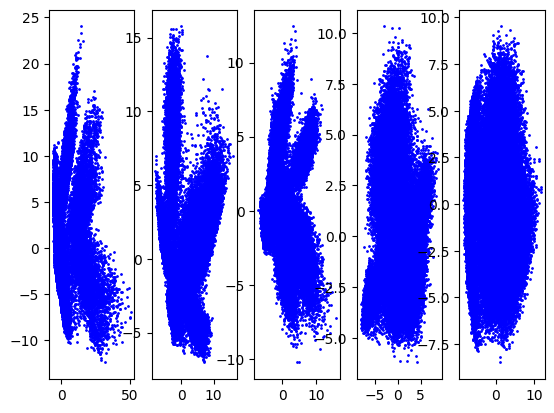

In [94]:
for i,k in enumerate(models):
    plt.subplot(1,len(models),i+1)
    project_latent(latents[k]) 
plt.show()

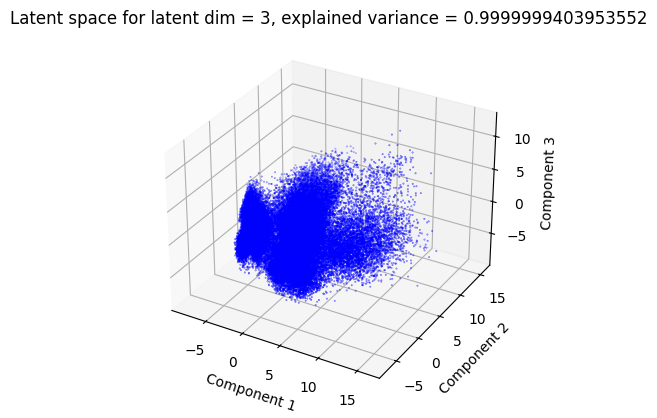

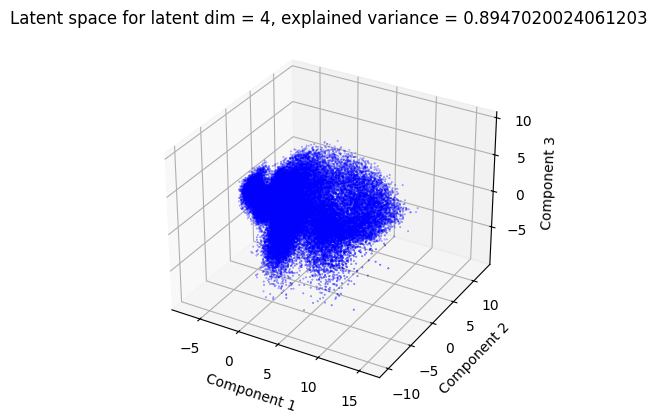

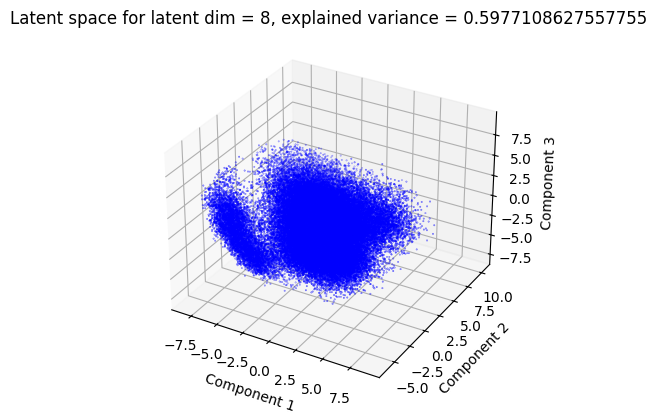

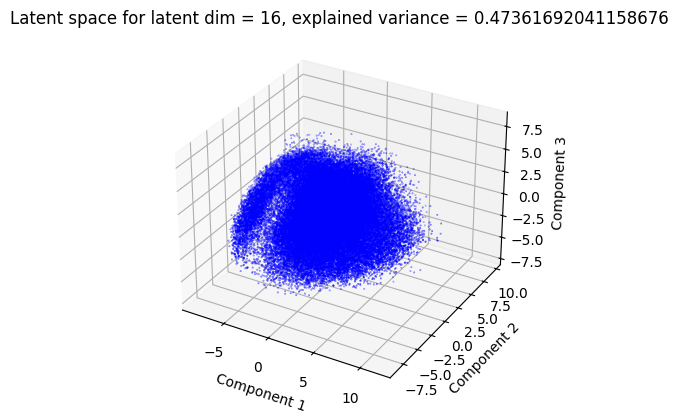

In [100]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_latent_space(latent_X):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(latent_X[:, 0], latent_X[:, 1], latent_X[:, 2], c='b', marker='o', s=0.1)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

for ld in models:
    if ld>2:
        pca = PCA(n_components=3)
        latent_X = pca.fit_transform(latents[ld])
        plot_3d_latent_space(latent_X)
        plt.title(f'Latent space for latent dim = {ld}, explained variance = {sum(pca.explained_variance_ratio_)}')

Digression:

Issue: 



- speed improvement is much less than theory value comparing GPU and CPU
    